In [1]:
%config InlineBackend.rc = {"figure.dpi": 72, "figure.figsize": (6.0, 4.0)}
%matplotlib inline

import abtem
import ase
import matplotlib.pyplot as plt
import numpy as np

(walkthrough:atomic_models)=
# Atomic models with ASE
abTEM uses the Atomic Simulation Environment ([ASE](https://wiki.fysik.dtu.dk/ase/)) for creating model atomic structures {cite}`ase`. ASE is a set of tools and Python modules for setting up, manipulating, visualizing and analyzing atomistic simulations. It is also used in conjunction with other simulation codes such as [GPAW](https://wiki.fysik.dtu.dk/gpaw/) for running DFT simulations. Here, we introduce the set of features of ASE needed for image simulations; please refer to the ASE documentation for a more general introduction.

## `Atoms`
The `Atoms` defines a collection of atoms. Here is how to set up an N<sub>2</sub> molecule by directly specifying the position of the two nitrogen atoms (in units of Ångstrom).

In [2]:
n2 = ase.Atoms("2N", positions=[(0.0, 0.0, 0.0), (0.0, 0.0, 1.10)], cell=[2, 2, 2])

A basic abTEM simulation only uses the positional coordinates, atomic numbers and the unit cell for creating electrostatic potentials. 

The atomic numbers is an array of integers.

In [3]:
n2.numbers

array([7, 7])

The $xyz$ positions is a $N\times 3$ array, where $N$ is the number of atoms.

In [4]:
n2.positions

array([[0. , 0. , 0. ],
       [0. , 0. , 1.1]])

The cell is slightly more complicated. When we access it here, we get three numbers, the length of each side of the cell. This is because the unit vectors of the cell are orthogonal and axis-aligned, hence the cell can be given as just the sides of a rectangular cuboid.

In [5]:
n2.cell

Cell([2.0, 2.0, 2.0])

In general, a cell is defined by three lattice vectors. We print the full representation of the cell below, where each row represents a lattice vector

In [6]:
np.array(n2.cell)

array([[2., 0., 0.],
       [0., 2., 0.],
       [0., 0., 2.]])

```{important}
The multislice algorithm as implemented in abTEM always requires that the unit vectors are orthogonal and axis-aligned, additionally, the cell must be periodic. Fulfilling both of these constraints, while creating a desired model structure is not always trivial, see [the bottom of this document](orthogonal) for an introduction to the problem.
```

## Import/export

ASE can import all the common atomic structure formats, see a full list [here](https://wiki.fysik.dtu.dk/ase/ase/io/io.html). Below we import a .cif-file defining a unit cell of strontium titanate (SrTiO<sub>3</sub>). 

In [7]:
srtio3 = ase.io.read("./data/SrTiO3.cif")

Of course, we can also write the structure back to disk.  

In [8]:
ase.io.write("./data/SrTiO3.cif", srtio3)

```{warning}
Unlike some other multislice simulation codes, abTEM does not use any Debye-Waller factors or partial occupations embedded in structure files.
```

You can obtain structure files for most crystal structures from internet databases through your browser. The structure file imported above was downloaded from the [materials project](https://materialsproject.org/)

We recommend this database because it is open-source and the data is high quality. It should be noted that structures in the materials project database are determined computationally, hence the structures may differ slightly from experiment.  

The easiest way to get structures from the materials project is through their web interface, note that you need a (free) account to download data. You can also access their database through a python API, below we use their API to obtain strontium titanate. To run this code you need an API key from the materials project and insert it in place of "your_api_key".
```python
from mp_api.client import MPRester
from pymatgen.io.ase import AseAtomsAdaptor

with MPRester("your_api_key") as mpr:
    docs = mpr.summary.search(material_ids=["mp-5229"], fields=["structure"])
    srtio3 = AseAtomsAdaptor().get_atoms(docs[0].structure)
```

## Visualizing structures
The simplest way to visualize the atoms is the `show_atoms` function. This function creates a `matplotlib` figure of a 2D orthogonal projection of the structure perpendicular to a specified plane.

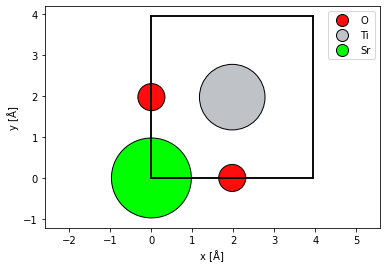

In [9]:
abtem.show_atoms(
    srtio3,
    plane="xy",  # show a perpendicular view to the 'xy' plane
    scale=0.5,  # scale the atoms to 0.5 of their covalent radii, default is 0.75
    legend=True,  # show a legend with the atomic symbols
);

The multislice algorithm requires periodic boundary conditions, hence we should imagine that the atoms at the boundary have an equivalent image at the opposite side. We can show the periodic images of the atoms at the boundary by setting `show_periodic=True`.

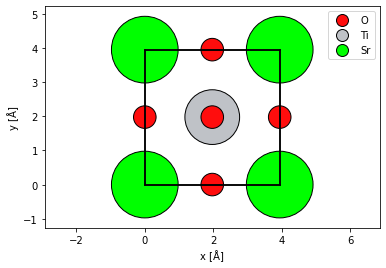

In [10]:
abtem.show_atoms(
    srtio3,
    show_periodic=True,
    scale=0.5,
    legend=True,
);

To view the atoms in an interactive 3d viewer, we can use ASE's `view` function. See the documentation [here](https://wiki.fysik.dtu.dk/ase/ase/visualize/visualize.html). Note that this may not work in a remote environment.
```python
from ase.visualize import view
view(srtio3)
```

If you are working in a remote environment or prefer to embed the 3d viewer in the notebook, you need to install [nglview](https://github.com/nglviewer/nglview). This will allow you to use the nglview backend for the `view` function.
```python
view(srtio3, viewer='nglview')
```

## Bulding structures

In addition to importing structures, ASE has tools for procedurally creating many common structures:

* Common bulk crystals: [`ase.build.bulk`](https://wiki.fysik.dtu.dk/ase/ase/build/build.html#ase.build.bulk)
* Bulk structures by its spacegroup: [`ase.spacegroup.crystal`](https://wiki.fysik.dtu.dk/ase/ase/spacegroup/spacegroup.html?highlight=crystal)
* Carbon nanotubes: [`ase.build.nanotube`](https://wiki.fysik.dtu.dk/ase/ase/build/build.html#nanotubes)
* Nanoparticles: [`ase.cluster`](https://wiki.fysik.dtu.dk/ase/ase/cluster/cluster.html)

As an example, we create a nanoparticle of gold by specifying 6 layers in the (100) directions, 9 in the (110) directions and 5 in the (111) directions.

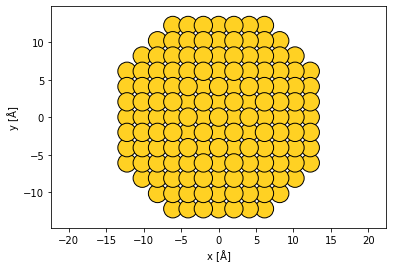

In [11]:
from ase.cluster import FaceCenteredCubic

surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
layers = [6, 9, 5]
latticeconstant = 4.08

nanoparticle = FaceCenteredCubic(
    "Au", surfaces, layers, latticeconstant=latticeconstant
)

abtem.show_atoms(nanoparticle, scale=0.9);

## Manipulating structures

The structure you import or build may not match your requirements or the requirements of abTEM. Here, we exemplify the most common manipulations needed for modifying atomic models for image simulation.

### Rotating structures
A common problem when creating model structures is choosing the imaging direction. abTEM always assumes that the imaging electrons travels along the $z$-axis in the direction from negative to positive coordinate values, hence choosing the propagation direction requires manipulating the atomic structure.

In this example, we rotate the nanoparticle into the (110) zone axis with the (100)-facet aligned with the $x$-axis. We first [`rotate`](https://wiki.fysik.dtu.dk/ase/ase/atoms.html?highlight=atoms#ase.Atoms.rotate) the atoms by $45 \ \mathrm{deg.}$ around $x$ and then by $\sim35.26 \ \mathrm{deg.}$ around $z$.

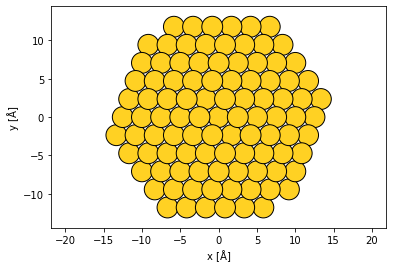

In [12]:
rotated_nanoparticle = nanoparticle.copy()

rotated_nanoparticle.rotate(45, "x")

rotated_nanoparticle.rotate(np.degrees(np.arctan(1 / np.sqrt(2))), "z")

abtem.show_atoms(rotated_nanoparticle, scale=1);

### Adding vacuum

The unit cell of the nanoparticle has *zero extent*.

In [13]:
rotated_nanoparticle.cell

Cell([0.0, 0.0, 0.0])

The extent of the unit cell determines the extent of the wave function, hence this is an *invalid cell* for abTEM simulations. We can use the `center` method to add vacuum around the unit cell.

In [14]:
centered_nanoparticle = rotated_nanoparticle.copy()

centered_nanoparticle.center(vacuum=2)

Showing the structure, we now see that there is a vacuum of $2 \ \mathrm{Å}$ separating the outermost atoms and the unit cell boundary (shown as thick black lines).   

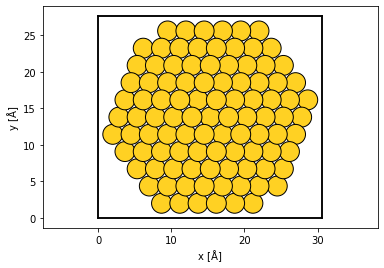

In [15]:
abtem.show_atoms(centered_nanoparticle, scale=1);

### Rotation of bulk structures

We just rotated the nanoparticle without considering the unit cell because the nanoparticle did not require periodicity at the cell boundary. This is not possible for periodic structures, in such cases ASE provides the [`surface`](https://wiki.fysik.dtu.dk/ase/ase/build/surface.html#create-specific-non-common-surfaces) function for picking the [zone axis](https://en.wikipedia.org/wiki/Zone_axis) of a given structure by providing the Miller indices. Below we create a SrTiO<sub>3</sub> structure in the (110) zone axis.

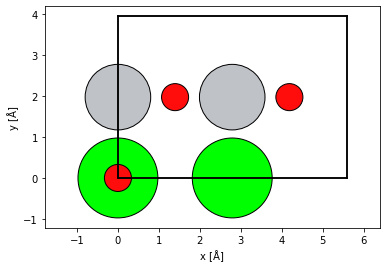

In [16]:
srtio3_110 = ase.build.surface(srtio3, indices=(1, 1, 0), layers=2, periodic=True)

abtem.show_atoms(srtio3_110, plane="xy", scale=0.5);

```{seealso}
For creating a view that does not correspond with a low-index zone axis, see [our introduction to creating arbitrary orthogonal structures](orthogonal) at the bottom of this document.
```

### Repeating the structure

It is often necessary to repeat the unit cell. For example, you may need to increase the thickness of the structure by repeating it along $z$. In STEM, the $xy$-extent of the model structure have to be large enough to accomodate the size of the probe to prevent self-interaction with its periodic images.

In ASE structures may be repeated by multiplying them with a tuple of 3 integers.

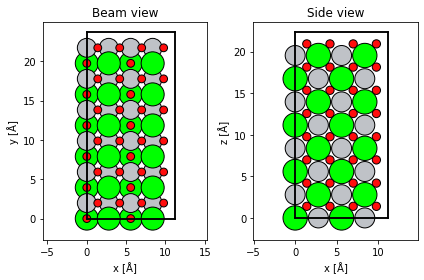

In [17]:
repeated_srtio3 = srtio3_110 * (2, 6, 4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))
abtem.show_atoms(repeated_srtio3, ax=ax1, title="Beam view")
abtem.show_atoms(repeated_srtio3, ax=ax2, plane="xz", title="Side view")
fig.tight_layout();

### Conditionally modifying atoms

The atomic positions and numbers are just numpy arrays and can be modified directly. The ASE documentation provides some tips [here](https://wiki.fysik.dtu.dk/ase/tips.html#atoms-objects).

We create a SrTiO<sub>3</sub> / LaTiO<sub>3</sub> interface by changing the atomic number of half the Sr atoms.

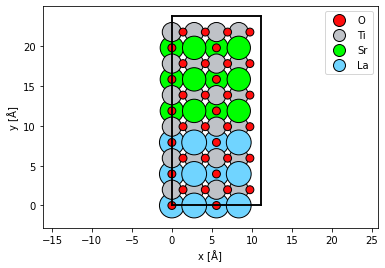

In [18]:
sto_lto_interface = repeated_srtio3.copy()

# select atoms with atomic number 38
mask_sr = sto_lto_interface.numbers == 38

# select atoms below the center
mask_left_side = sto_lto_interface.positions[:, 1] < sto_lto_interface.cell[1, 1] / 2

# combine selection
mask_combined = mask_sr * mask_left_side

# assign new atomic numbers to selection
sto_lto_interface.numbers[mask_combined] = 57

abtem.show_atoms(sto_lto_interface, legend=True);

### Scaling structures

The structure created above uses the lattice constant of SrTiO<sub>3</sub> calculated from DFT. Below we scale the structure to have the average experimental lattice constant of SrTiO<sub>3</sub> and LaTiO<sub>3</sub>. 

In [19]:
scaled_sto_lto_interface = sto_lto_interface.copy()

a_sr = 3.905
a_la = 3.97
a_new = (3.905 + 3.97) / 2
a_old = srtio3.cell[0, 0]

new_cell = sto_lto_interface.cell * a_new / a_old

scaled_sto_lto_interface.set_cell(new_cell, scale_atoms=True)

```{note}
We modified the STO/LTO interface above without any regard to the atomic-scale physics. In some, not most cases, your model should be calculated from an accurate atomistic model, e.g. density functional theory.
```

### Combining multiple structures

Some complex hetero-structures can only be created by combining multiple component structures. As an example, we create a simple model of a nanoparticle supported on amorphous carbon.

Below, the amorphous carbon is created by randomly displacing the atoms of a diamond structure.

In [20]:
substrate = ase.build.bulk("C", cubic=True)

# repeat substrate
substrate *= (10, 10, 10)

# displace atoms with a standard deviation of 50 % of the bond length
rng = np.random.default_rng(seed=10)
substrate.positions[:] += rng.normal(size=(len(substrate), 3)) * 0.5 * 1.54

# wrap the atoms displaced outside the cell back into the cell
substrate.wrap()

We will use the nanoparticle created above as our starting point for the nanoparticle. We delete the atoms with a value of $y$ less than $\mathrm{5} \ Å$, then the nanoparticle is positioned with respect to the substrate by centering and finally shifting the $y$-coordinates of the atoms.

In [21]:
cut_nanoparticle = centered_nanoparticle.copy()

mask = cut_nanoparticle.positions[:, 1] < 5

# deletion *requires* providing the indices, i.e. boolean indexing does not work
del cut_nanoparticle[np.where(mask)[0]]

# center nanoparticle relative to substrate
cut_nanoparticle.set_cell(substrate.cell)
cut_nanoparticle.center()

# shift nanoparticle in the y-direction
cut_nanoparticle.positions[:, 1] += 27

The substrate and nanoparticle can be combined by adding the models, lastly the models are centered along the $z$-axis with a vacuum of $5 \ \mathrm{Å}$. 

In [22]:
supported_nanoparticle = substrate + cut_nanoparticle

supported_nanoparticle.center(axis=1, vacuum=5)

We show the supported nanoparticle with `merge=0.5`, this will merge overlapping atoms within $0.5 \ \mathrm{Å}$ to up speed plotting.

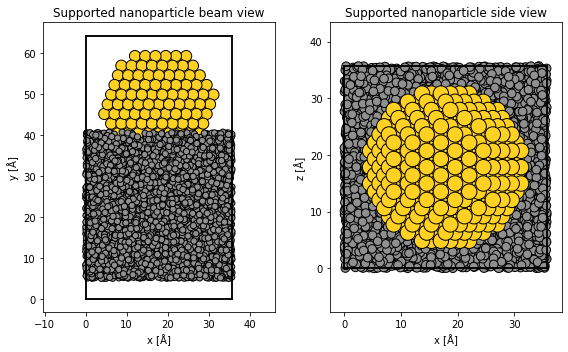

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))
abtem.show_atoms(
    supported_nanoparticle,
    ax=ax1,
    title="Supported nanoparticle beam view",
    merge=0.5,
    scale=1,
)
abtem.show_atoms(
    supported_nanoparticle,
    ax=ax2,
    plane="xz",
    scale=1,
    title="Supported nanoparticle side view",
    merge=0.5,
)
fig.tight_layout();

(orthogonal)=
## Orthogonal and periodic supercells

The multislice algorithm requires an orthogonal and periodic atomic structure as its input. However, taking any arbitrary structure and making it periodic and orthogonal is not always trivial, we have an in-depth tutorial on this problem here.

Below we briefly introduce a tool we have created to solve this problem. To demonstrate the tool, we start by creating a graphene structure with the its minimal unit cell. 

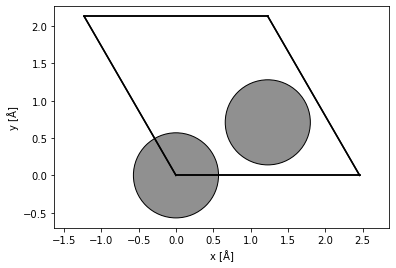

In [24]:
graphene = ase.build.graphene(vacuum=2)

abtem.show_atoms(graphene);

The minimal unit cell of graphene is hexagonal. To make the unit cell orthogonal, we can use abTEM's `orthogonalize_cell` function. 

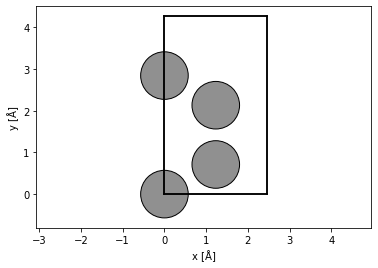

In [25]:
orthogonal_graphene, transform = abtem.orthogonalize_cell(
    graphene, max_repetitions=10, return_transform=True
)

abtem.show_atoms(orthogonal_graphene);

Hexagonal cells can be made orthogonal by doubling the cell size without introducing any strain. However, this is not always possible, hence we can return the transformation required for making the structure orthogonal, by setting `return_transform=True`.

Printing this transformation, we see that no additional transformation was necessary, as expected.

In [29]:
from abtem.structures import pretty_print_transform

pretty_print_transform(transform)

euler angles (degrees): 	 x = 0.000, 	 y = 0.538, 	 z = 0.000
normal strains (percent): 	 x = 0.000, 	 y = 0.000, 	 z = -0.000
shear strains (percent): 	 xy = 0.000, 	 xz = 0.000, 	 xz = 0.000


A common, less trivial example, is the creation of models with a specific rotation relative to the beam. Here, we want to view FCC gold at a 10 degree angle.

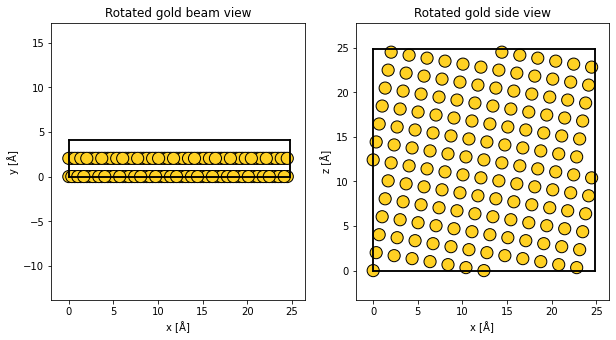

In [27]:
desired_rotation = 10

gold = ase.build.bulk("Au", cubic=True)

gold.rotate(desired_rotation, "y", rotate_cell=True)

gold, transform = abtem.orthogonalize_cell(
    gold, max_repetitions=10, return_transform=True
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

abtem.show_atoms(gold, ax=ax1, scale=0.5, title="Rotated gold beam view")

abtem.show_atoms(gold, ax=ax2, plane="xz", scale=0.5, title="Rotated gold side view");

As shown below, creating the rotated structure required an additional rotation of $0.538 \ \mathrm{degrees}$ around the $y$-axis. This means that within the contraint of repeating the structure at most 10 times in either direction, the closest periodic and orthogonal structure is rotated by $10.538 \ \mathrm{degrees}$ and not the desired $10.0 \ \mathrm{degrees}$. This may be close enough, if not then `max_repetitions` can be increased. For example, within a `max_repetitions` of 20, the required transform is just $-0.008 \ \mathrm{degrees}$ around the $y$-axis.

In [28]:
pretty_print_transform(transform)

euler angles (degrees): 	 x = 0.000, 	 y = 0.538, 	 z = 0.000
normal strains (percent): 	 x = 0.000, 	 y = 0.000, 	 z = -0.000
shear strains (percent): 	 xy = 0.000, 	 xz = 0.000, 	 xz = 0.000
